In [1]:
# Load data

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from util import Util
from qos_data_manager import QosDataManager
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer
from matplotlib.backends.backend_pdf import PdfPages

# configuration
############################################################
np.random.seed(1001)
report_directory = "reports" 
mode = 'qos'
excel_file_video = r"video_dataset_with_costs(qos).xlsx"
excel_file_mrs = r"mrs_dataset_with_costs(qos).xlsx"

# set data mode ('mrs' or 'video')
data_mode = "video"

if data_mode == "mrs":
    excel_file = excel_file_mrs
elif data_mode == "video":
    excel_file = excel_file_video

used_features = ['Users',
                 'Avg RAM used (MB)',
                 #'Avg RAM (unused, KiB)',
                 'Disk read bytes', 
                 #'Disk write bytes rate',
                 'End-to-end',
                 #'No. SLO violations, threshold 5s (%)',
                 'Avg. CPU utilization (%)',
                 #'Max CPU utilization (%)', 
                 #'Min RAM',
                 #'Min free RAM (KiB)', 
                 #'NW Ingress (GB)',
                 'NW Egress (GB)'
                    ]
outcome_label = 'End-to-end'
############################################################

dataManager = QosDataManager(excel_file, outcome_label, used_features, data_mode=data_mode)
dataManager.load()
dataManager.exportDataset()        

def transformX(X):
    scaler = StandardScaler()
    X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)       
    return X

def transformY(Y):
    data = Y.copy().values
    data = np.sqrt(data)
    ret = pd.Series(data)
    return ret

def invTrans(X):
    return X*X

dataManager.setXTransform(transformX)
dataManager.setYTransform(transformY)

m_all = dataManager.getMetrics()
if data_mode == 'mrs':
    m_large = dataManager.getMetricsDBLarge()
    #m_xlarge = dataManager.getMetricsDBXLarge()
elif data_mode == 'video':
    m_large = dataManager.getMetricsVideoDBLarge()
    m_medium = dataManager.getMetricsVideoDBMedium()
    m_small = dataManager.getMetricsVideoDBSmall()

working_metrics = m_large
working_metrics_label = "large"
print(len(working_metrics))

util = Util()
util.setInvTrans(invTrans)
working_metrics.head()
X,Y = dataManager.getXY_panda(working_metrics)


21 features removed (std +/- 3) -  large
1 features removed (std +/- 3) -  medium
16 features removed (std +/- 3) -  small
15 features removed (std +/- 3) -  all
219


## VIF 

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import cross_validation
metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)

vif = [variance_inflation_factor(X_train.values, j) for j in range(X_train.shape[1])]
df = pd.DataFrame()
df["feature"] = X_train.columns.values
df["vif"] = vif
df

,feature,vif
0,Avg RAM used (MB),45.694325
1,Avg. CPU utilization (%),3.040984
2,Disk read bytes,NaN
3,NW Egress (GB),106.440066
4,Users,34.782040


# Selected features

In [4]:
X,Y = dataManager.getXY_panda(working_metrics)
print("selected features:")
selected_features_names = X.columns
print(selected_features_names.values)

selected features:
['Avg RAM used (MB)' 'Avg. CPU utilization (%)' 'Disk read bytes'
 'NW Egress (GB)' 'Users']


# Pearson correlation plots

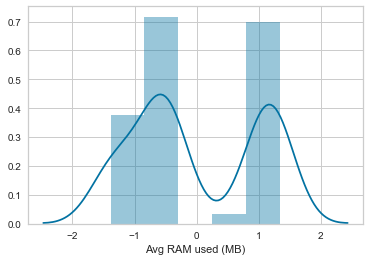

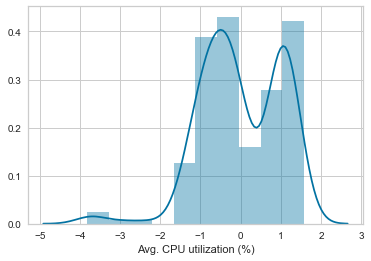

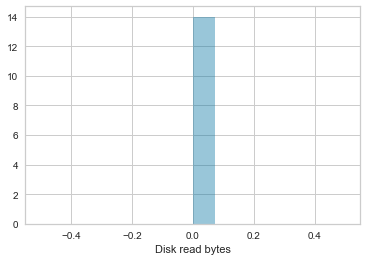

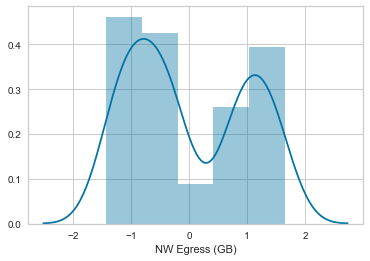

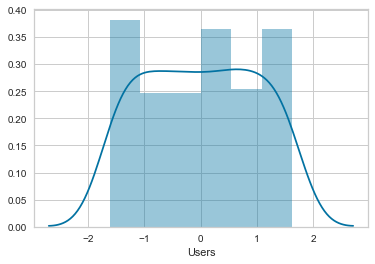

In [5]:
# jont plots for comparing features (Pearson correlation)
metrics = working_metrics
for name in selected_features_names:
        #sns.jointplot(name, outcome_label, data=metrics, kind="reg")
        sns.distplot(X[name])
        plt.show()


# Regression results report

In [6]:
from sklearn import cross_validation
from sklearn import metrics as m
from sklearn.preprocessing import StandardScaler

regression_models = dict()

test_size = 0.3

## MARS

In [7]:
from pyearth import Earth
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
import eli5
from eli5.sklearn import PermutationImportance
#from matplotlib import pyplot

model = Earth(max_degree=2, penalty=1.0, minspan_alpha = 0.01, endspan_alpha = 0.01, endspan=5)
model = AdaBoostRegressor(base_estimator=model, n_estimators=20, learning_rate=0.01, loss="exponential")
#model = BaggingRegressor(base_estimator=mars, n_estimators=25)

model.fit(X_train,Y_train)
pred = model.predict(X_test)

#print(model.summary())


util.regression_report(Y_test, pred,"MARS", X.shape[1])
regression_models["MARS"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}


###Dodano za Permutation importance
###################################
perm = PermutationImportance(model, n_iter=150, random_state=1).fit(X_test, Y_test)
print("")
print("")
print("Eli5.show_weights")
print("=================")
eli5.show_weights(perm, feature_names = X_test.columns.tolist())
###################################


MAE: 56.35725744761379
MSE: 10871.442414369816
MAPE: 1.5504797063036357
RMSE: 104.26620936031873
EVS: 0.9977700552950431
AIC: -16.967098820304777
AICc: -15.967098820304777
BIC: 634.3453218064456
R2: 0.9977665300301722
R2(adj): 0.9975804075326866


Eli5.show_weights


Weight,Feature
2.2935 ± 0.7169,Users
0.0299 ± 0.0147,NW Egress (GB)
0.0001 ± 0.0001,Avg RAM used (MB)
0 ± 0.0000,Disk read bytes
0 ± 0.0000,Avg. CPU utilization (%)


# Linear regression with polynomial fit

In [8]:
from sklearn.linear_model import LinearRegression

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
linear_regression = LinearRegression()
model = Pipeline([("polynomial_features", polynomial_features),
                ("linear_regression", linear_regression)])
model.fit(X_train, Y_train)
true = Y_test
pred = model.predict(X_test)
util.regression_report(true, pred,"Polynomial", X.shape[1])
regression_models["PolyLinearRegression"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

MAE: 64.94280699323645
MSE: 14845.5920012683
MAPE: 1.8786319319258802
RMSE: 121.84248848931271
EVS: 0.9969551305128961
AIC: -17.59022601452327
AICc: -16.59022601452327
BIC: 654.908519215656
R2: 0.9969500658095451
R2(adj): 0.9966959046270072


# Lasso Regression

In [9]:
from sklearn.linear_model import LassoCV

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
lasso_reg = LassoCV()
model = Pipeline([("polynomial_features", polynomial_features),
                ("lasso_regression", lasso_reg)])

model.fit(X_train, Y_train)

# make predictions on the testing set
pred = model.predict(X_test)
true = Y_test

util.regression_report(true, pred, "Lasso", X.shape[1])
regression_models["Lasso Regression"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}


MAE: 73.04699031540659
MSE: 12307.40247015348
MAPE: 3.4199737846058906
RMSE: 110.9387329572205
EVS: 0.9974740556864241
AIC: -17.215221858407066
AICc: -16.215221858407066
BIC: 642.5333820638211
R2: 0.9974715210019107
R2(adj): 0.9972608144187366


# Lasso Lars

In [10]:
from sklearn.linear_model import LassoLarsCV
import eli5
from eli5.sklearn import PermutationImportance

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

polynomial_features = PolynomialFeatures(degree=3, include_bias=False)
lasso_lars_reg = LassoLarsCV()
model = Pipeline([("polynomial_features", polynomial_features),
                ("lasso_lars_regression", lasso_lars_reg)])

model.fit(X_train, Y_train)
pred = model.predict(X_test)
true = Y_test
util.regression_report(true, pred,"LassoLars", X.shape[1])
regression_models["LassoLars"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

###Dodano za Permutation importance
###################################
perm = PermutationImportance(model, n_iter=150, random_state=1).fit(X_test, Y_test)
print("")
print("")
print("Eli5.show_weights")
print("=================")
eli5.show_weights(perm, feature_names = X_test.columns.tolist())
###################################

MAE: 57.499123351455644
MSE: 10228.154797020712
MAPE: 2.0354930179589132
RMSE: 101.13434034501195
EVS: 0.9978992431123492
AIC: -16.845108425910855
AICc: -15.845108425910855
BIC: 630.3196387914463
R2: 0.9978986894548878
R2(adj): 0.9977235802427951


Eli5.show_weights


Weight,Feature
1.8986 ± 0.4892,Users
0.0009 ± 0.0004,NW Egress (GB)
0.0003 ± 0.0002,Avg RAM used (MB)
0.0001 ± 0.0001,Avg. CPU utilization (%)
0 ± 0.0000,Disk read bytes


##  Ridge Regression

In [11]:
from sklearn.linear_model import RidgeCV

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

polynomial_features = PolynomialFeatures(degree=3, include_bias=False)
ridge = RidgeCV()
model = Pipeline([("polynomial_features", polynomial_features),
                ("ridge_regression", ridge)])

model.fit(X_train, Y_train)

pred = model.predict(X_test)
true = Y_test

util.regression_report(true, pred, "Ridge", X.shape[1])
regression_models["Ridge"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

MAE: 64.98150618247219
MSE: 10937.86827073682
MAPE: 1.6893079511111768
RMSE: 104.58426397282156
EVS: 0.997753118394765
AIC: -16.97928188518565
AICc: -15.97928188518565
BIC: 634.7473629475146
R2: 0.9977528832527015
R2(adj): 0.99756562352376


# ElasticNet Regression

In [12]:
from sklearn.linear_model import ElasticNetCV

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

polynomial_features = PolynomialFeatures(degree=4, include_bias=False)
enet = ElasticNetCV(random_state=0)
model = Pipeline([("polynomial_features", polynomial_features),
                ("enet_regression", enet)])

model.fit(X_train, Y_train)

pred = model.predict(X_test)
true = Y_test

util.regression_report(true, pred,"ElasticNet", X.shape[1])
regression_models["ElasticNet Regression"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

MAE: 155.78831669066668
MSE: 35800.47219059403
MAPE: 5.007157729172331
RMSE: 189.21012708254818
EVS: 0.9926939119055735
AIC: -19.350742208019263
AICc: -18.350742208019263
BIC: 713.0055536010236
R2: 0.9926450165032698
R2(adj): 0.9920321012118756


## ExtraTrees Regressor

In [13]:
from sklearn.ensemble import ExtraTreesRegressor

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

model = ExtraTreesRegressor(n_estimators=10, random_state=0)
model.fit(X_train, Y_train)

pred = model.predict(X_test)
true = Y_test

util.regression_report(true, pred, "ExtraTrees Regressor", X.shape[1])
regression_models["ExtraTrees Regressor"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

MAE: 59.609203396311564
MSE: 13972.122327312687
MAPE: 1.1640388153344772
RMSE: 118.20373229011294
EVS: 0.9971319642937214
AIC: -17.46894820618073
AICc: -16.46894820618073
BIC: 650.906351540352
R2: 0.9971295147006837
R2(adj): 0.9968903075924073


## Random Forest Regressor

In [14]:
from sklearn.ensemble import RandomForestRegressor

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

model = RandomForestRegressor(random_state=0)
model.fit(X_train, Y_train)

pred = model.predict(X_test)
true = Y_test

util.regression_report(true, pred,"Random Forest", X.shape[1])
regression_models["Random Forest"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

MAE: 67.52870092047988
MSE: 13579.132280835538
MAPE: 1.6633426755420553
RMSE: 116.52953394241109
EVS: 0.9972416101276682
AIC: -17.411888488503866
AICc: -16.411888488503866
BIC: 649.0233808570156
R2: 0.9972102520521586
R2(adj): 0.9969777730565051


## K-Neighbours Regression

In [15]:
from sklearn.neighbors import KNeighborsRegressor

X,Y = dataManager.getXY_panda(working_metrics)
X = X[selected_features_names]
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

# instantiate
model = KNeighborsRegressor(n_neighbors=2)

# fit the model to the training data (learn the coefficients)
model.fit(X_train, Y_train)

# make predictions on the testing set
pred = model.predict(X_test)
true = Y_test

util.regression_report(true, pred, "K-Neighbours Regression", X.shape[0])
regression_models["K-Neighbours Regression"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

MAE: 83.88488979423806
MSE: 65570.94400016141
MAPE: 1.6247000675628127
RMSE: 256.06824090496156
EVS: 0.9867414519053844
AIC: 407.43891461597855
AICc: -218.27537109830712
BIC: 1649.5329932027516
R2: 0.986528858937427
R2(adj): 1.0056858712277095


# Report

In [16]:
util.regression_results.reset_index(drop=True, inplace=True)
util.get_aic_bic()
print(util.regression_results)

          MAE           MSE      MAPE        RMSE       EVS         AIC  \
0   56.357257  10871.442414  1.550480  104.266209  0.997770  -16.967099   
1   64.942807  14845.592001  1.878632  121.842488  0.996955  -17.590226   
2   73.046990  12307.402470  3.419974  110.938733  0.997474  -17.215222   
3   57.499123  10228.154797  2.035493  101.134340  0.997899  -16.845108   
4   64.981506  10937.868271  1.689308  104.584264  0.997753  -16.979282   
5  155.788317  35800.472191  5.007158  189.210127  0.992694  -19.350742   
6   59.609203  13972.122327  1.164039  118.203732  0.997132  -17.468948   
7   67.528701  13579.132281  1.663343  116.529534  0.997242  -17.411888   
8   83.884890  65570.944000  1.624700  256.068241  0.986741  407.438915   

         AICc          BIC        R2   R2(adj)   AIC delta    BIC delta  \
0  -15.967099   634.345322  0.997767  0.997580    0.121990     4.025683   
1  -16.590226   654.908519  0.996950  0.996696    0.745118    24.588880   
2  -16.215222   642.5333

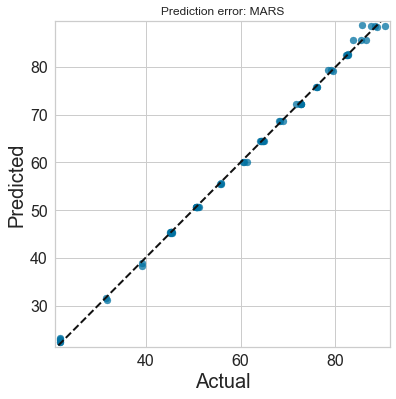

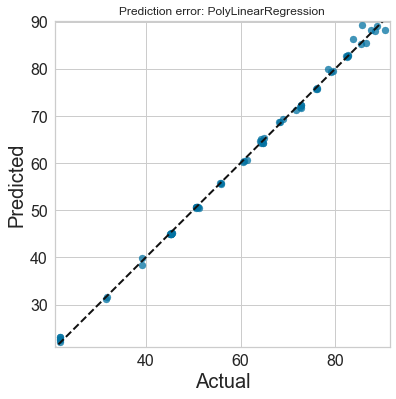

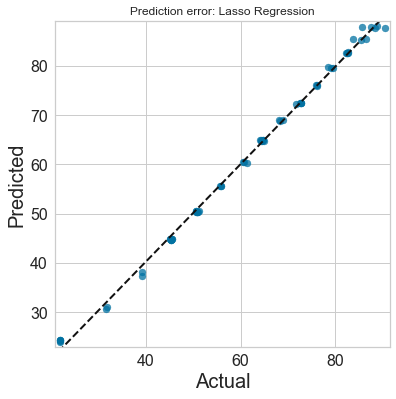

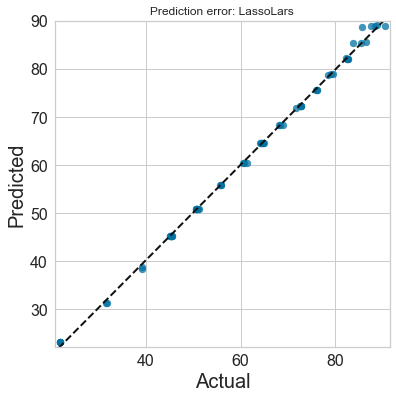

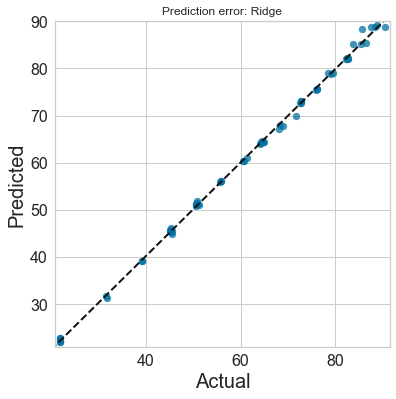

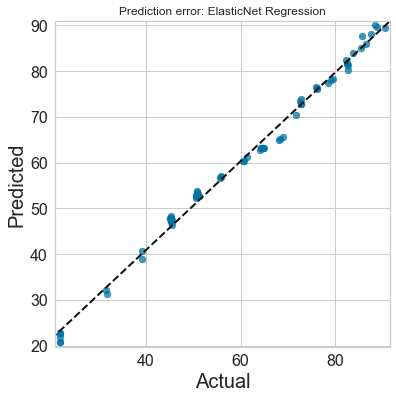

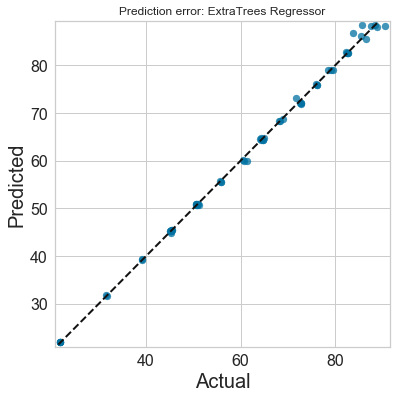

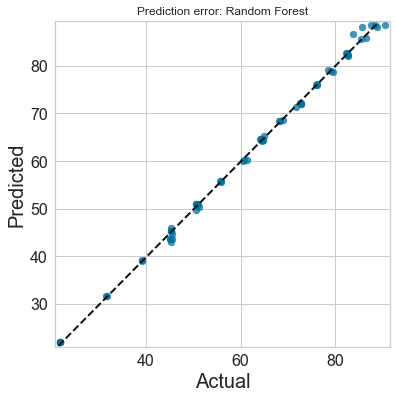

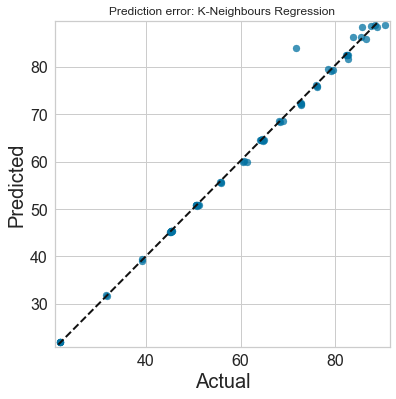

In [17]:
with PdfPages(report_directory + "/qos_" + data_mode + '_graphs_prediction_error_test.pdf') as pdf:
    for model_info_label in regression_models:
        f, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlabel('Actual', fontsize=20)
        ax.set_ylabel('Predicted', fontsize=20)
        ax.tick_params(axis='both', which='major',labelsize=16)
        ax.tick_params(axis='both', which='minor',labelsize=16)
        util.visualize_prediction_error(regression_models[model_info_label])
        ax.legend().set_visible(False)
        ax.set_title('Prediction error: ' + model_info_label)
        pdf.savefig(f, bbox_inches='tight')
        
        #util.visualize_residuals_plot(regression_models[model_info_label])
        #pdf.savefig(f)


# Residuals graphs

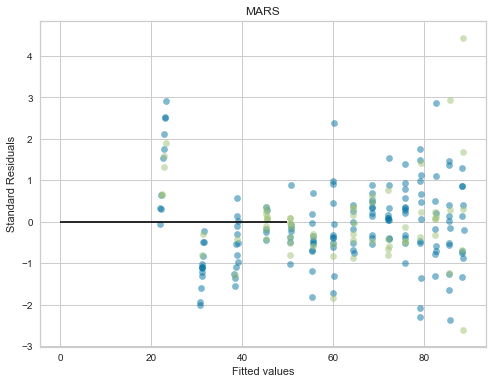

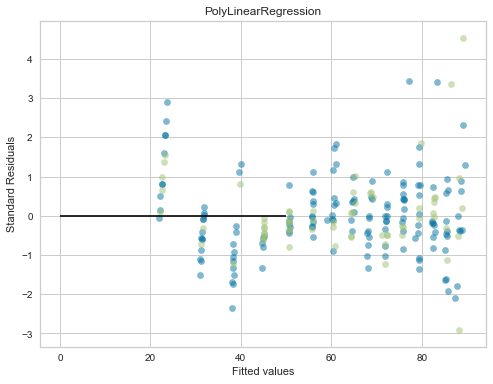

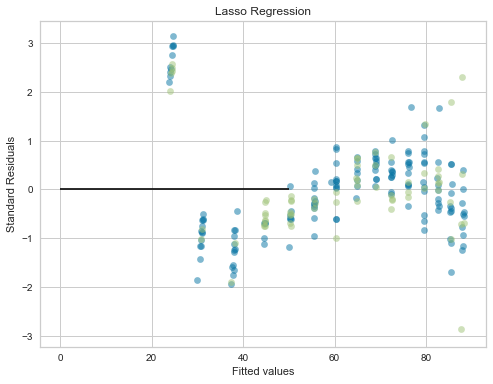

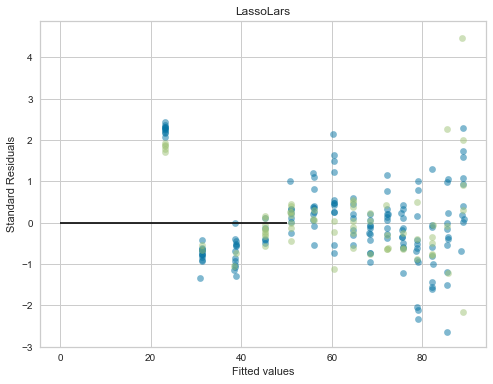

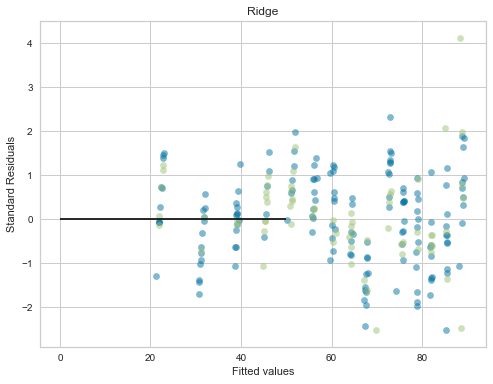

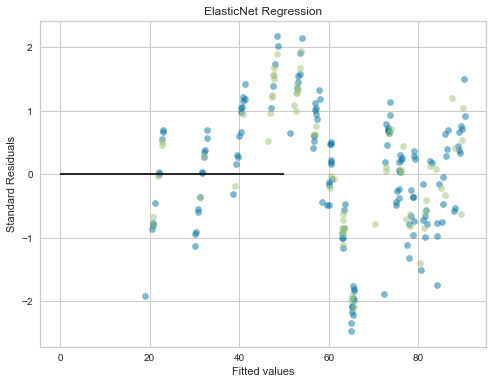

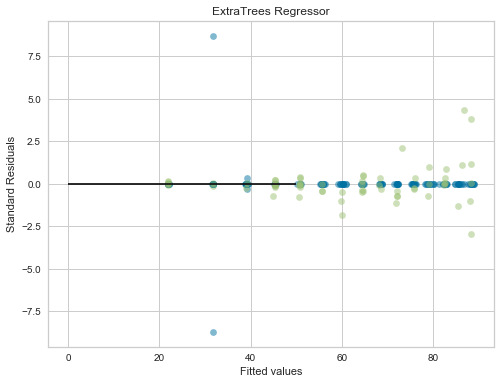

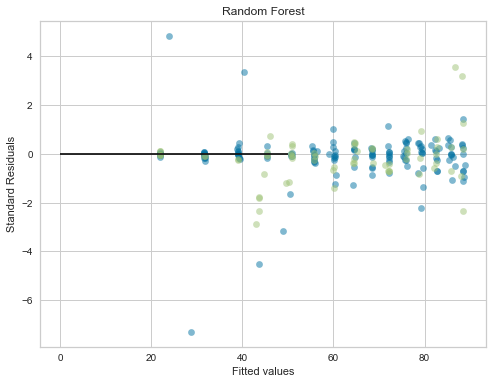

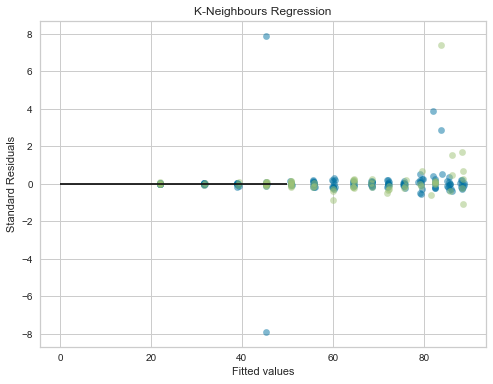

In [18]:
with PdfPages(report_directory + "/qos_" + data_mode + '_graphs_residuals.pdf') as pdf:
    for model_info_label in regression_models:
        f, ax = plt.subplots(figsize=(8, 6))
        util.residuals_graph(regression_models[model_info_label], model_info_label)
        pdf.savefig(f)

# Prediction graphs

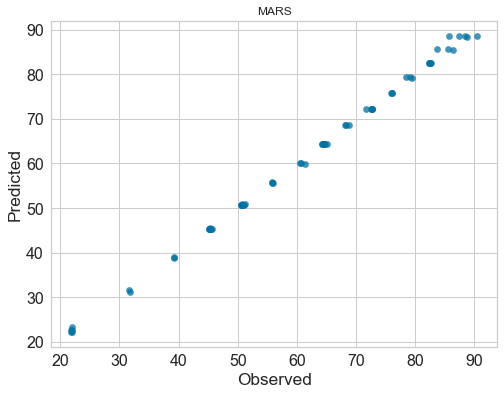

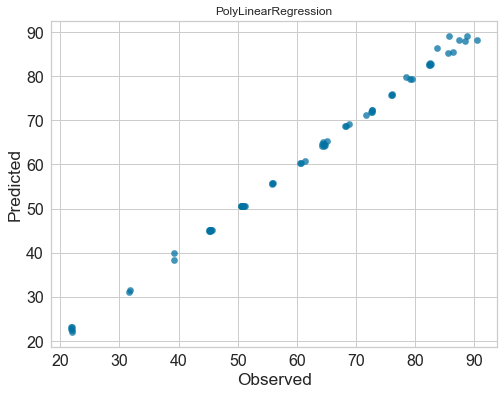

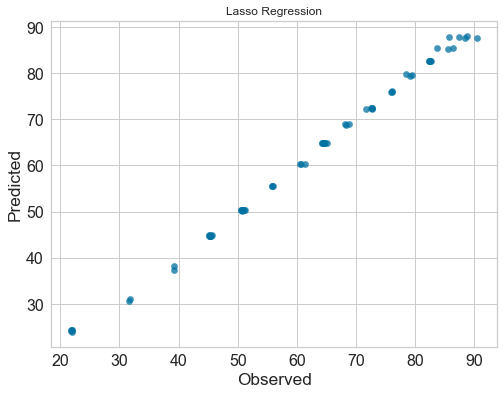

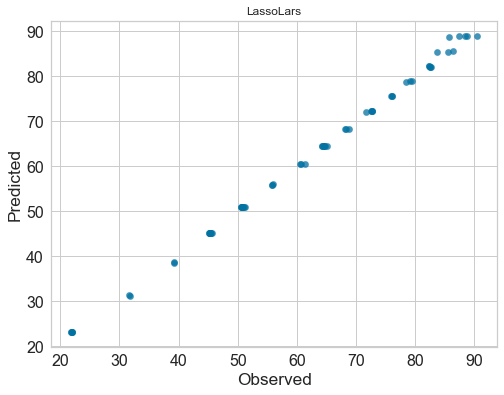

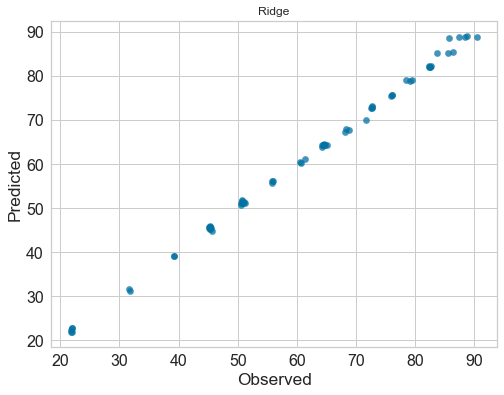

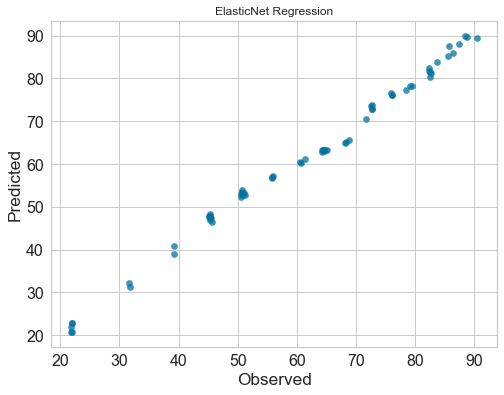

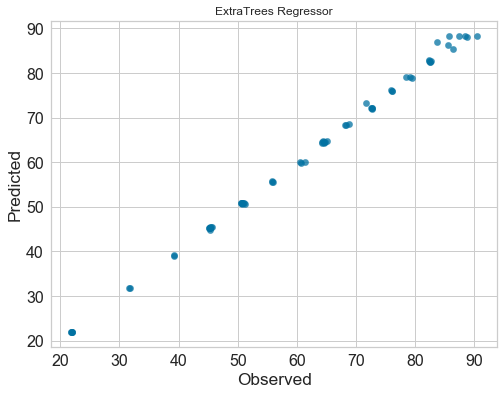

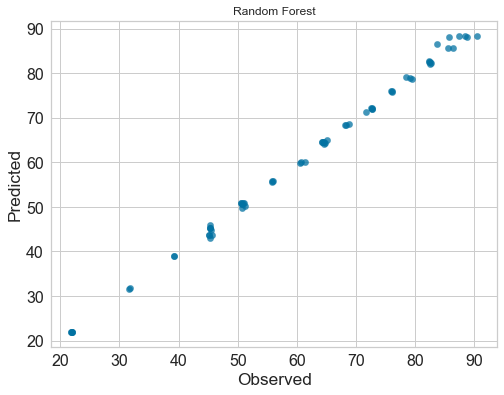

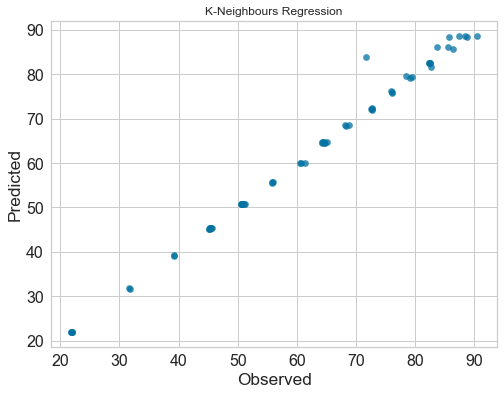

In [19]:
with PdfPages(report_directory + "/qos_" + data_mode + '_graphs_prediction.pdf') as pdf:
    for model_info_label in regression_models:
        f, ax = plt.subplots(figsize=(8, 6))
        util.pred_true_graph(regression_models[model_info_label], model_info_label)
        pdf.savefig(f)

# QQ graphs

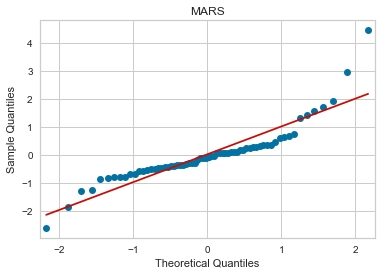

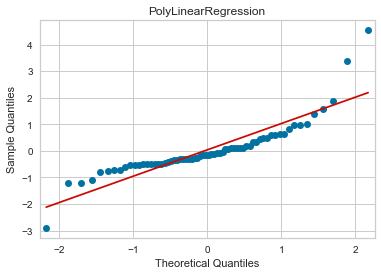

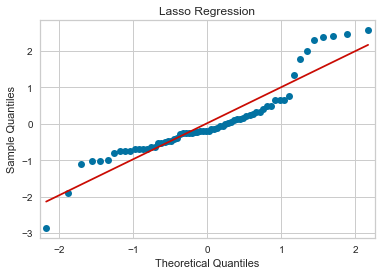

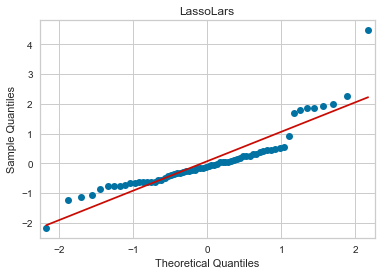

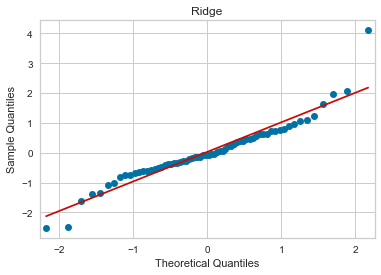

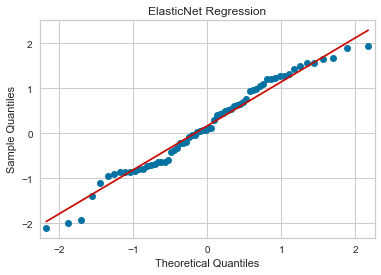

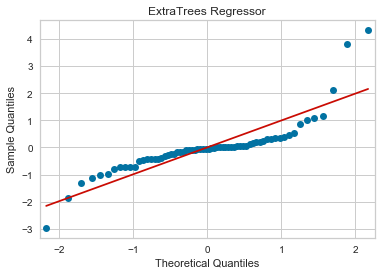

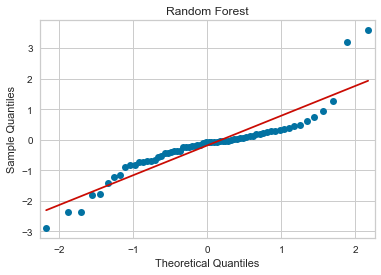

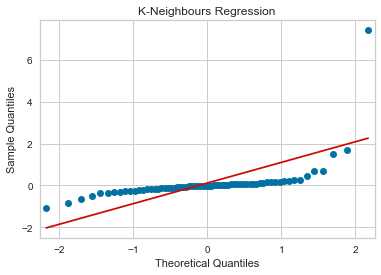

In [20]:
with PdfPages(report_directory + "/qos_" + data_mode + '_graphs_qq.pdf') as pdf:
    for model_info_label in regression_models:
        util.qq_graph(regression_models[model_info_label], model_info_label, pdf)

# Scale location graphs

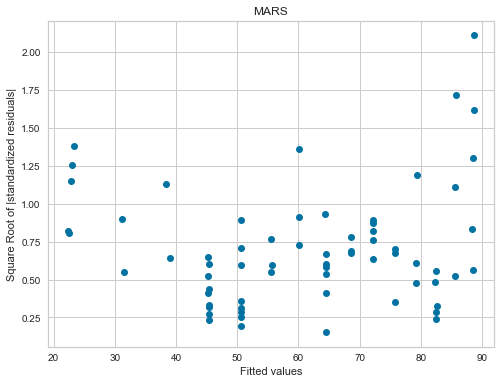

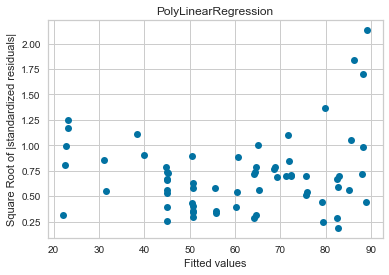

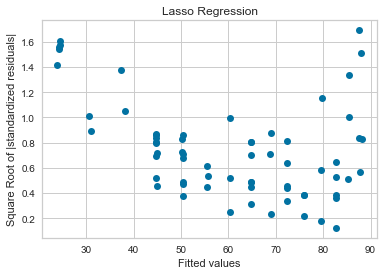

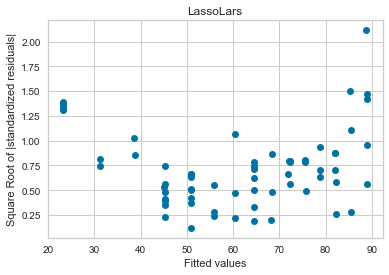

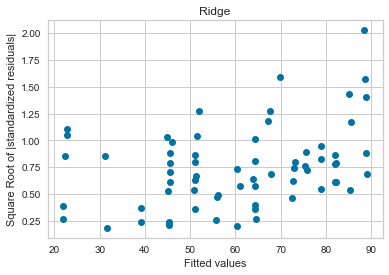

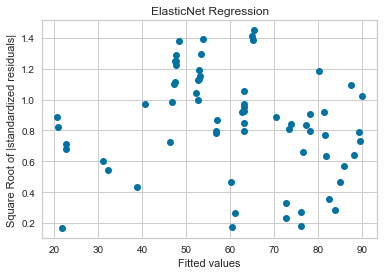

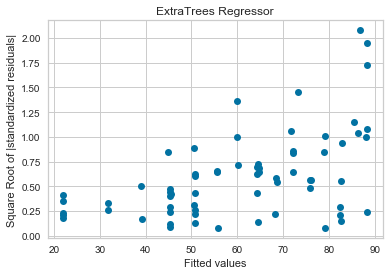

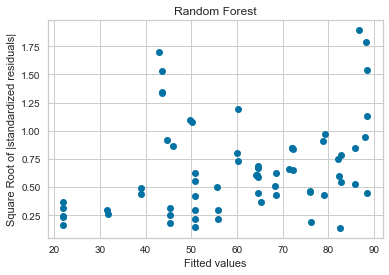

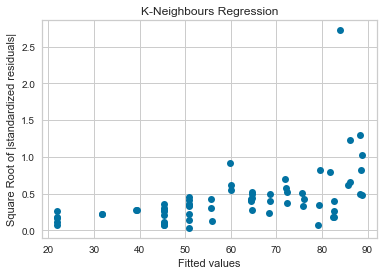

In [21]:
with PdfPages(report_directory + "/qos_" + data_mode + '_graphs_scale_location.pdf') as pdf:
    f, ax = plt.subplots(figsize=(8, 6))
    for model_info_label in regression_models:
        util.scale_location_graph(regression_models[model_info_label], model_info_label)
        pdf.savefig(f)